In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plot
import math

from datetime import timedelta
from datetime import datetime

import requests
import json 

import re

In [2]:
#id directories
data_dir = os.getcwd()

In [3]:
#supply data
items_df = pd.read_excel('item_sets.xlsx')
orders_df = pd.read_excel('Critical_Supply_Dashboard_19 items_Aug_19.xlsx', 
                          sheet_name='DATA_Orders')
orders_df.columns = orders_df.columns.str.replace(' ', '')
items_df.columns = items_df.columns.str.replace(' ', '')
orders_df.columns = orders_df.columns.str.replace('.', '_')
orders_df = orders_df.iloc[1:]
orders_df = orders_df[orders_df['Category'].notnull()]

In [4]:
#demand data
r = requests.get('https://data.seattle.gov/resource/33kz-ixgy.json')
calls_df = pd.read_json(r.text)

r = requests.get('https://data.seattle.gov/resource/fire-911.json')
fire_reponses_df = pd.read_json(r.text)

call_types_df = pd.read_excel('City_of_Seattle_set_of_call_types.xlsx')

In [5]:
calls_df['classification'] = ''
calls_df['date_clean'] = ''
calls_df['week'] = ''
calls_df['year'] = ''

for i in range(len(calls_df)):
    classification_temp = re.split(' - ', calls_df['initial_call_type'].iloc[i])
    time_temp = re.split(' ', calls_df['original_time_queued'].iloc[i])
    calls_df['classification'].iloc[i] = classification_temp[0]
    calls_df['date_clean'].iloc[i] = time_temp[0]

for i in range(len(calls_df)):
    date_temp = datetime.strptime(calls_df['date_clean'].iloc[i], "%d/%W/%Y")
    calls_df['year'].iloc[i] = date_temp.isocalendar()[0]
    calls_df['week'].iloc[i] = date_temp.isocalendar()[1]

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#calculate arrival rates per week
calls_df_arrival_per_week = calls_df[['classification',
                                              'year', 
                                              'week', 'cad_event_number']].groupby(['classification',
                                              'year', 
                                              'week']).agg('count')

In [7]:
#clean orders data frame to get types

orders_df['FullItemList'] = ''
temp = ['Disinfectant Wipes', 
        'Hand Sanitizer','Hand Soap']


for i in range(len(orders_df)):
    
    category_temp = orders_df['Category'].iloc[i]
    
    if category_temp in temp:
        orders_df['FullItemList'].iloc[i] = category_temp
    elif category_temp in ['N-95 Filter']:
        orders_df['FullItemList'].iloc[i] = 'Masks (N95)'   
    elif category_temp in ['Surgical Mask']:
        orders_df['FullItemList'].iloc[i] = 'Masks (Surgical)'
    elif category_temp in ['PAWS']:
        orders_df['FullItemList'].iloc[i] = 'Antimicrobial (PAWS) Wipes'
    elif category_temp in ['DS', 'DSS']:
        orders_df['FullItemList'].iloc[i] = 'Disinfecting Solution'
    elif category_temp in ['IA']:
        orders_df['FullItemList'].iloc[i] = 'Isopropyl Alcohol'
    elif ((category_temp.find('Gloves') != -1) and (orders_df['Description'].iloc[i].find('exam') != -1)):
        orders_df['FullItemList'].iloc[i] = 'Nitrile Gloves (Public Safety)'
    elif ((category_temp.find('Gloves') != -1) and (orders_df['Description'].iloc[i].find('exam') == -1)):
        orders_df['FullItemList'].iloc[i] = 'Nitrile Gloves (General Use)'
    elif category_temp in ['CMask']:
        orders_df['FullItemList'].iloc[i] = 'Masks (Cloth)'
    elif category_temp in ['Therm']:
        orders_df['FullItemList'].iloc[i] = 'Thermometer'
    elif (category_temp.find('Tyvek') != -1):
        if (category_temp.find('NH') != -1):
            orders_df['FullItemList'].iloc[i] = 'Tyvek Suits'
        else:
            orders_df['FullItemList'].iloc[i] = 'Tyvek Suits w/hoods'
    elif category_temp in ['Gowns']:
        orders_df['FullItemList'].iloc[i] = 'Surgical Gowns'
    elif category_temp in ['HS Refill Bags']:
        orders_df['FullItemList'].iloc[i] = 'Purell (1200 ml stand refill)'
    elif (category_temp.find('Toilet') != -1):
        orders_df['FullItemList'].iloc[i] = 'Toilet Paper'
    else:
        orders_df['FullItemList'].iloc[i] = 'NA'
        
orders_df = orders_df[orders_df['FullItemList'] != 'NA']

In [8]:
#delay time df
delay_time_df = orders_df[['FullItemList', 'Date', 'EstimatedDeliveryDate']]

#clean to only include df with estimated/realized delay times
delay_time_df = delay_time_df[delay_time_df['EstimatedDeliveryDate'] != 'TBD']
delay_time_df = delay_time_df[delay_time_df['EstimatedDeliveryDate'].notnull()]
delay_time_df['Date'] = pd.to_datetime(delay_time_df['Date'])
delay_time_df['EstimatedDeliveryDate'] = (delay_time_df['EstimatedDeliveryDate']).astype(str)
delay_time_df['filter'] = delay_time_df['EstimatedDeliveryDate'].str.contains('-') #to filter out other misc errors
delay_time_df = delay_time_df[delay_time_df['filter'] == True]
delay_time_df['EstimatedDeliveryDate'] = pd.to_datetime(delay_time_df['EstimatedDeliveryDate'])
delay_time_df['delay_time'] = delay_time_df['EstimatedDeliveryDate'] - delay_time_df['Date']

#merge with items df
delay_time_df = delay_time_df.merge(items_df, on = 'FullItemList', how='left')

In [9]:
#generate f_k_i_tdiff distributions

#start with masks
delay_time_df_masks_dist = delay_time_df[delay_time_df['ItemType'] == 'Masks']
delay_time_df_masks_dist = delay_time_df_masks_dist[['ItemListID', 
                                                     'FullItemList', 'delay_time', 
                                                     'filter']]

In [10]:
delay_time_df_masks_dist

,ItemListID,FullItemList,delay_time,filter
0,3.0,Masks (Cloth),10 days,True
1,3.0,Masks (Cloth),38 days,True
2,3.0,Masks (Cloth),105 days,True
151,1.0,Masks (N95),4 days,True
152,1.0,Masks (N95),56 days,True
153,1.0,Masks (N95),38 days,True
157,2.0,Masks (Surgical),7 days,True
158,2.0,Masks (Surgical),29 days,True
159,2.0,Masks (Surgical),11 days,True
160,2.0,Masks (Surgical),28 days,True


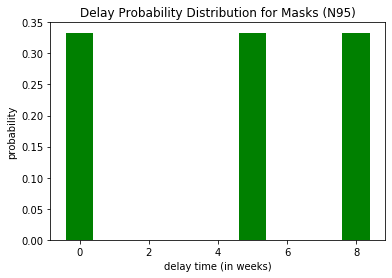

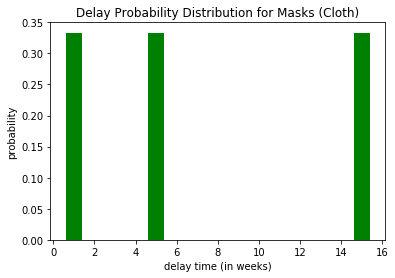

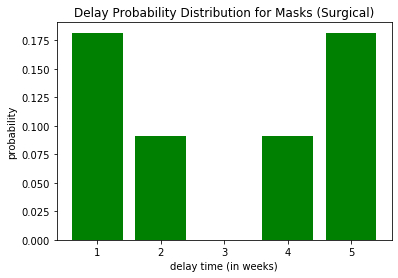

In [11]:
#start with masks
delay_time_df_masks_dist = \
delay_time_df_masks_dist.groupby(['ItemListID', 
                                  'FullItemList', 
                                  'delay_time']).agg({'filter': 'count'}).reset_index()

delay_time_df_masks_dist_temp = \
delay_time_df_masks_dist[['ItemListID', 'filter']].groupby(['ItemListID']).agg({'filter': 'sum'}).reset_index()

delay_time_df_masks_dist = delay_time_df_masks_dist.merge(delay_time_df_masks_dist_temp, 
                                                         on = 'ItemListID',
                                                         how = 'left')

delay_time_df_masks_dist['probability'] = \
delay_time_df_masks_dist['filter_x']/delay_time_df_masks_dist['filter_y']

delay_time_df_masks_dist = delay_time_df_masks_dist[['ItemListID', 'FullItemList', 'delay_time', 'probability']]

for s in set(delay_time_df_masks_dist['FullItemList']):
    temp_df = \
    delay_time_df_masks_dist[delay_time_df_masks_dist['FullItemList'] == s]
    delay_time = (temp_df['delay_time']).astype(str)
    #print(delay_time)
    delay_time = delay_time.str.replace(' 00:00:00.000000000', '')
    delay_time = delay_time.str.replace(' days', '')
    delay_time = delay_time.astype(np.float)
    delay_time = [math.floor(x /7) for x in delay_time]
    probability = temp_df['probability']
    plot.bar(delay_time, probability, color='green')
    plot.xlabel("delay time (in weeks)")
    plot.ylabel("probability")
    plot.title("Delay Probability Distribution for " + s)
    plot.show()

In [ ]:
delay_time_df_masks_dist